Module 3 Assignment - Part 4: Use TF/Keras to Create both an RNN and an LSTM and Compare Results
---

For this part, you can choose any dataset you like. I recommend choosing text data (such as movie reviews: <https://keras.io/api/datasets/imdb/>) and predicting sentiment. However, I will allow you to select any sequential dataset you like as long as it is appropriate for RNNs.

Use TF/Keras to create two models. The first will be a simple RNN. The second will be a LSTM model.

There are great examples online that you can review and learn from (but not copy :)). You can also have a look at one of my examples that compares ANN, CNN, RNN, and LSTM: <https://gatesboltonanalytics.com/?page_id=903>

Just as in Parts 1 and 2 (I will not repeat the requirements again here - but please assume them) you will illustrate your process and results. You will also discuss and illustrate a comparison between the RNN and the LSTM models.

---


In [1]:
#libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import seaborn as sns

2023-12-01 05:14:22.594923: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 05:14:22.653144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

I started messing around with the movie data, but ended struggling for a while since I'm less familar about working with text data, etc. So instead, I'm going to be using data from my undergrad research work, which is a time series data: NASA's [OMNI dataset](https://omniweb.gsfc.nasa.gov/).

However, one thing to note. The problem I tackle with this data is a **regression problem not a classification problem**. So I won't be outputting a confusion matrix, but I will be sure to use another form of performance evaluation visualization. 

## Data loading

If I submitted as I intended, the csv data should've been included in my submission (titled "`omni_df.csv`")

In [2]:
omni_df = pd.read_csv('omni_df.csv')

In [3]:
omni_df.head()

,Epoch,BX_GSE,BY_GSE,BZ_GSE,Vx,Vy,Vz,proton_density,T,AE_INDEX,AL_INDEX,AU_INDEX,SYM_H,ASY_H
0,2000-01-01 00:00:00,-5.94,0.24,-0.15,NaN,NaN,NaN,NaN,NaN,668.0,-486.0,182.0,-44.0,48.0
1,2000-01-01 00:01:00,-5.88,2.17,0.53,-662.6,7.3,-46.5,3.12,343841.0,638.0,-487.0,151.0,-45.0,48.0
2,2000-01-01 00:02:00,-5.71,3.23,1.44,-661.4,2.4,-46.3,3.24,326583.0,666.0,-527.0,139.0,-45.0,48.0
3,2000-01-01 00:03:00,-5.33,3.80,1.84,-659.8,-8.4,-56.2,3.11,306470.0,615.0,-474.0,141.0,-45.0,48.0
4,2000-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,554.0,-418.0,136.0,-45.0,47.0


## EDA

### Data columns and their meanings:

**JK Note to TAs:** It's not crucial to this work for you to understand these for the purposes of this assignment, but just in case it might be helpful. 

Can also refer to their [about OMNI data page](https://omniweb.gsfc.nasa.gov/html/ow_data.html)

Essentially this is all solar wind data

- `Epoch`: Date and Time (datetime index)
- Interplanetary Magnetic Field (units = nano-Teslas (nT))
    - `BX_GSE`: x-component of Magnetic Field in [GSE coordinate system](https://www.spenvis.oma.be/help/background/coortran/coortran.html#GSE) 
    - `BY_GSE`: y-component of Magnetic Field in GSE coordinate system
    - `BX_GSE`: z-component of Magnetic Field in GSE coordinate system
- Solar Wind velocity (km/sec)
    - `Vx`: Solar wind velocity in x
    - `Vy`: Solar wind velocity in y
    - `Vz`: Solar wind velocity in z
- `proton_density`: Proton density in the solar wind (n/cc)
- `T`: Temperature (K)
- Geomagnetic Indices 
    - all units = nano Teslas (nT)
    - [Auroral Electrojet](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ngdc.stp.indices:G00584#:~:text=The%20AU%20and%20AL%20indices%20are%20intended%20to%20express%20the,Show%20more...)
        - `AE_INDEX`: Auroral Electrojet Index (AE = AU-AL)
        - `AU_INDEX`: Auroral Electrojet upper
        - `AL_INDEX`: Auroral Electrojet lower
    - [SYM/ASY H](https://wdc.kugi.kyoto-u.ac.jp/aeasy/asy.pdf)
        - `SYM_H`: Longitudinally symmetric disturbance of geomagnetic H-component
            - Sym-H is the same is the [Dst Index](https://www.ngdc.noaa.gov/stp/geomag/dst.html), but at higher resolution
        - `ASY_H`: Longitudinally asymmetric disturbance of geomagnetic H-component



For my purposes the features (predictor variables, model input, etc. however you want to call it) are:
`BX_GSE`, `BY_GSE`, `BZ_GSE`, `AE_INDEX`, `AL_INDEX`, `AU_INDEX`, `SYM_H`, `ASY_H`

And the targets ("label", the model output, etc.) are: `Vx`, `Vy`, `Vz`, `proton_density`, `T`

In [4]:
omni_df.describe()

,BX_GSE,BY_GSE,BZ_GSE,Vx,Vy,Vz,proton_density,T,AE_INDEX,AL_INDEX,AU_INDEX,SYM_H,ASY_H
count,8.888632e+06,8.888632e+06,8.888632e+06,7.679877e+06,7.679877e+06,7.679877e+06,7.679877e+06,7.673164e+06,9.552960e+06,9.552960e+06,9.552960e+06,9.552960e+06,9.552960e+06
mean,2.586364e-03,5.997560e-02,2.418269e-03,-4.353644e+02,-1.359368e+00,-2.238432e+00,5.999525e+00,9.880642e+04,1.792767e+02,-1.114364e+02,6.784032e+01,-1.203162e+01,2.011680e+01
std,3.660013e+00,4.227383e+00,3.395529e+00,1.053745e+02,2.552232e+01,2.266174e+01,4.988173e+00,9.744486e+04,2.102548e+02,1.550540e+02,7.383967e+01,1.971669e+01,1.593993e+01
min,-4.951000e+01,-5.109000e+01,-6.064000e+01,-1.136500e+03,-8.649000e+02,-3.104000e+02,3.000000e-02,5.430000e+02,1.000000e+00,-4.141000e+03,-9.750000e+02,-4.900000e+02,0.000000e+00
25%,-2.650000e+00,-2.670000e+00,-1.730000e+00,-4.948000e+02,-1.630000e+01,-1.490000e+01,3.000000e+00,3.551900e+04,4.200000e+01,-1.470000e+02,1.900000e+01,-1.900000e+01,1.100000e+01
50%,0.000000e+00,2.000000e-02,0.000000e+00,-4.126000e+02,-3.500000e+00,-2.100000e+00,4.600000e+00,7.002000e+04,9.300000e+01,-4.500000e+01,4.100000e+01,-9.000000e+00,1.600000e+01
75%,2.630000e+00,2.760000e+00,1.730000e+00,-3.556000e+02,1.140000e+01,1.020000e+01,7.240000e+00,1.308720e+05,2.400000e+02,-1.800000e+01,9.000000e+01,-1.000000e+00,2.400000e+01
max,3.995000e+01,5.509000e+01,6.438000e+01,-9.340000e+01,3.291000e+02,4.516000e+02,8.095000e+01,7.617765e+06,4.192000e+03,7.900000e+01,2.063000e+03,1.510000e+02,9.840000e+02


## Data Cleaning

In [5]:
# number of missing values in each column
omni_df.isnull().sum()

Epoch                   0
BX_GSE             664328
BY_GSE             664328
BZ_GSE             664328
Vx                1873083
Vy                1873083
Vz                1873083
proton_density    1873083
T                 1879796
AE_INDEX                0
AL_INDEX                0
AU_INDEX                0
SYM_H                   0
ASY_H                   0
dtype: int64

The data clearly has some missing values, so we'll use the I'll combat by interpolating the input parameters, and dropping the other rows with missing target values. Can do so with the `interpolate_input()` function I defined below.

(The following is the same code I used to clean my data for work.)

In [6]:
def interpolate_input(df,features,targets,interpolation_method = 'linear',has_time_col=True,
                      drop_target_nan=True,includes_TH=False,th_len=15,include_target_th = False):
    
    #Creating X and y df from Time History data th_df (if applicable)-----------------------------------------------
    if includes_TH:
        X_col = []
        y_col =[]
        
        for f in features:
            for i in range(0,th_len+1):
                X_col.append(f+'_m{}'.format(i))
        if include_target_th:
            for tt in targets:
                for j in range(1,th_len+1):
                    X_col.append(tt+'_m{}'.format(j))
        for tt in targets:
            y_col.append(tt+'_m0')
            
        features = X_col
        targets =y_col
    #---------------------------------------------------------------------------------------------------------------    
    
    
    #separate df into features only & targets only dataframes========================================================
    
    feat_df = df[features].astype('float32')
    targ_df = df[targets].astype('float32')
    if has_time_col:
        if includes_TH:
            time = df['time']
        else:
            time = df['Epoch']      #may want to change this so it doesn't only for dfs with column = 'Epoch'
    
    #interpolate features-only dataframe==============================================================================
    interpolated_feat_df = feat_df.interpolate(interpolation_method)    #if method not specified when function 
                                                                        # is passed, defaults to linear interpolation
    #combine df's together again=====================================================================================
    if has_time_col:
        concat_df = pd.concat([time,interpolated_feat_df,targ_df],axis=1)
    else:
        concat_df = pd.concat([interpolated_feat_df,targ_df],axis=1)
        
    print("New df with interpolated input created")
    # TO drop or NOT to drop... the nan of target parameters---------------------------------------------------------
    if drop_target_nan:
        new_df = concat_df.dropna()
        print("Target Nan's were dropped (no missing values in df;can be used for model training & testing)")
    else:
        new_df = concat_df
        print("Target NaN's were NOT dropped (dataframe still contains missing values)")
    
        
    return new_df

In [7]:
features = ['BX_GSE','BY_GSE','BZ_GSE','AE_INDEX','AL_INDEX','AU_INDEX','SYM_H','ASY_H']
targets = ['Vx']

In [8]:
df = interpolate_input(omni_df,features=features,
                  targets=targets, 
                  has_time_col=True,
                  drop_target_nan=True,
                  includes_TH=False)

New df with interpolated input created
Target Nan's were dropped (no missing values in df;can be used for model training & testing)


In [9]:
df.isnull().sum()

Epoch       0
BX_GSE      0
BY_GSE      0
BZ_GSE      0
AE_INDEX    0
AL_INDEX    0
AU_INDEX    0
SYM_H       0
ASY_H       0
Vx          0
dtype: int64

Viola! No more missing data

### Training and Testing sets

The following is also code directly from my work code (so there might be some uneccessary things).

In [10]:
def train_test_dataframes(df,features,targets,split_type='random',test_size=0.2,scale=None,
                          includes_TH=False,th_len=15,include_target_th = False):
    
    #Creating X and y df from Time History data th_df (if applicable)-----------------------------------------------
    if includes_TH:
        X_col = []
        y_col =[]
        
        for f in features:
            for i in range(0,th_len+1):
                X_col.append(f+'_m{}'.format(i))
        if include_target_th:
            for tt in targets:
                for j in range(1,th_len+1):
                    X_col.append(tt+'_m{}'.format(j))
        for tt in targets:
            y_col.append(tt+'_m0')
    else:
        X_col = features
        y_col = targets
    #--------------------------------------------------------------------------------------------------------------- 
    
    X = df[X_col].astype('float32')
    y = df[y_col].astype('float32')
    
    # Training-Test Split=====================================================
    #(Random) Train-Test Split-----------------------------------------------
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= test_size,random_state=123)
    split = 'Random split'
        
    # (Sequential) Train-Test Split------------------------------------------
    if split_type == 'sequential':
    
        train_size = 1-test_size
        
        X_train = X[:int(train_size*len(X))]   #values up to % indicated by train_size
        X_test = X[int(train_size*len(X)):]    #remaining sequential values from X
        y_train = y[:int(train_size*len(y))]
        y_test = y[int(train_size*len(y)):]
        
        split = 'Sequential split'
    # Print split type--------------------------------------------------------
    print('Train-Test split was:', split)
    
    #Scaling==================================================================
    if scale is not None:
        scaler = scale
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print('X_train & X_test have been scaled using {}'.format(str(scale)))
    else:
        print('X_train & X_test are not scaled')
        
    print('Dataframes are complete')  

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    return X_train,X_test,y_train,y_test



In [11]:
X_train,X_test,y_train,y_test = train_test_dataframes(df,
                      features=features,
                      targets=targets,
                      split_type='sequential',
                      test_size=0.2,
                      scale=MinMaxScaler(),
                      includes_TH=False)

Train-Test split was: Sequential split
X_train & X_test have been scaled using MinMaxScaler()
Dataframes are complete


### Data Shapes

In [12]:
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (6143901, 8)
y_train shape: (6143901, 1)
X_test shape: (1535976, 8)
y_test shape: (1535976, 1)


# RNN Model

In [14]:
RNN_Model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=15, output_dim=128, input_length=8),
  tf.keras.layers.SimpleRNN(units =50),
  ## If not using Embedding, you would use SimpleRNN(units, input_shape=(x,y))
  tf.keras.layers.Dense(32,activation='linear'),
  tf.keras.layers.Dense(25,activation='linear'),
  tf.keras.layers.Dense(1, activation='linear')
])
RNN_Model.summary()

2023-12-01 05:14:57.650430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (100)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 128)            1920      
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                8950      
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 25)                825       
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13,353
Trainable params: 13,353
Non-trainable params: 0
_________________________________________________________________


In [15]:
loss_function = tf.keras.losses.MeanSquaredError()
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
accuracy = keras.metrics.Accuracy()
RNN_Model.compile(
                 loss=loss_function,
                 metrics=[accuracy],
                 optimizer=adam
                 )

In [16]:
%%time
Hist=RNN_Model.fit(X_train,y_train, epochs=5, validation_data=(X_test, y_test),batch_size=5000)

Epoch 1/5
1229/1229 [==============================] - 137s 108ms/step - loss: 13077.6484 - accuracy: 0.0000e+00 - val_loss: 9769.1123 - val_accuracy: 0.0000e+00
Epoch 2/5
1229/1229 [==============================] - 129s 105ms/step - loss: 11455.3564 - accuracy: 1.6276e-07 - val_loss: 9731.5137 - val_accuracy: 0.0000e+00
Epoch 3/5
1229/1229 [==============================] - 136s 111ms/step - loss: 11461.5820 - accuracy: 0.0000e+00 - val_loss: 9723.2129 - val_accuracy: 0.0000e+00
Epoch 4/5
1229/1229 [==============================] - 136s 111ms/step - loss: 11464.7051 - accuracy: 0.0000e+00 - val_loss: 9854.2178 - val_accuracy: 0.0000e+00
Epoch 5/5
1229/1229 [==============================] - 138s 112ms/step - loss: 11466.3037 - accuracy: 1.1393e-06 - val_loss: 9725.4590 - val_accuracy: 0.0000e+00
CPU times: user 29min 33s, sys: 5min 16s, total: 34min 49s
Wall time: 11min 17s


## Evaluate Model

### Loss & Accuracy vs. Epoch plots

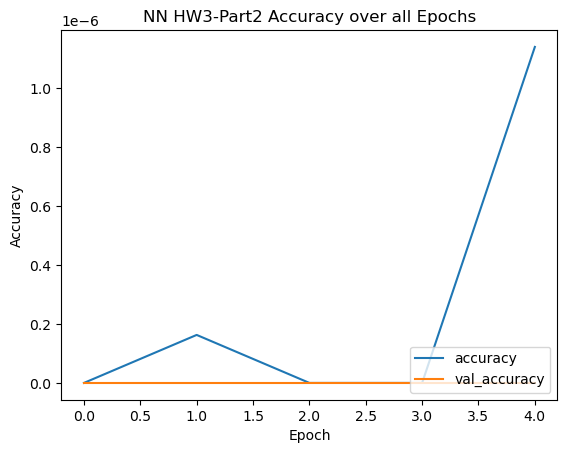

In [19]:
# Accuracy plot
plt.plot(Hist.history['accuracy'], label='accuracy')
plt.plot(Hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("NN HW3-Part2 Accuracy over all Epochs")

#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

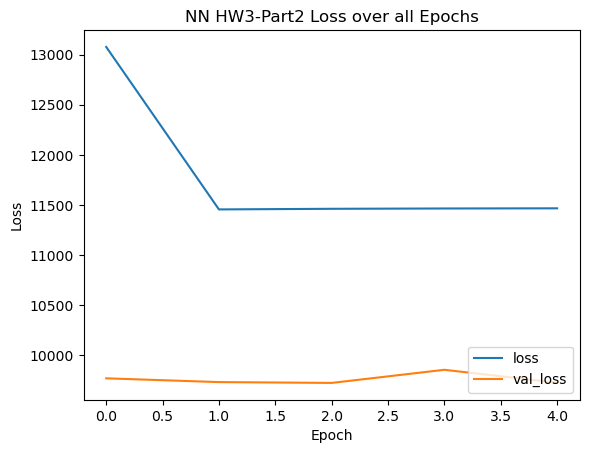

In [20]:
# Loss plot
plt.plot(Hist.history['loss'], label='loss')
plt.plot(Hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("NN HW3-Part2 Loss over all Epochs")
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [23]:
Eval_Loss, Eval_Accuracy = RNN_Model.evaluate(X_test, y_test,batch_size=5000)

308/308 [==============================] - 12s 40ms/step - loss: 9725.4590 - accuracy: 0.0000e+00


### Test Model with Predictions

In [24]:
pred = RNN_Model.predict(X_test,batch_size=5000)

  3/308 [..............................] - ETA: 13s

308/308 [==============================] - 13s 41ms/step


In [25]:
# Preview results
i = 5   # index to check
print("Prediction for X_test[{}]:".format(i),pred[i])
print("\n Label for X_test[{}] (y_test[{}]):".format(i,i), y_test[i])

Prediction for X_test[5]: [-434.3235]

 Label for X_test[5] (y_test[5]): [-430.3]


Again, as this is not a classification problem, I'm afraid I can't provide a confusion matrix as visualization of performance. However, I will use the same "pretty" plot I used to evaluate my models for my research work. 

It's a density scatter plot of the prediction values plotted against the true values. So, it kinda follows to same concept of the confusion matrix in the sense that the "best" performance has the most points along the diagonal.

But first it requires some preliminary code:

In [45]:
#pip install mpl-scatter-density
import mpl_scatter_density
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

def density_scatter( x , y, line_z, ax = None, sort = True, bins = 20, nlevels=10, plot_cbar=True, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = False )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    
    z[np.where(z<=0.0)] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    
    #x & y values for plotting line of best fit for the model
    a, b = np.polyfit(x, y, 1)
    fit_line_x = [-1*line_z,line_z]
    fit_line_y = a*np.array(fit_line_x)+b
    
    cs = ax.scatter( x, y, c=z, marker='.', cmap='plasma', alpha=0.8, **kwargs )     # 'marker' was added by JK
    ax.plot([-1*line_z,line_z], [-1*line_z,line_z], 'forestgreen', linewidth=3., label='R = 1.0')
    ax.plot(fit_line_x, fit_line_y, linestyle='--',color='red', 
            linewidth=2., label='R = {0:.2f} (model)'.format(pearsonr(x,y)[0]))
    #norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cticks = list(np.linspace(0,np.ceil(len(x)/10.)*10,nlevels))
    
    # print(z.max())
    cbar = plt.colorbar(cs,ax=ax,ticks=cticks)
    cbar.ax.set_yticklabels(["{:.1f}".format(i) for i in cbar.get_ticks()])
    cbar.set_label('# per bin', fontsize=12, labelpad=0.75)
    if not plot_cbar:
        cbar.remove()
    return ax

def ml_model_performance(target,prediction,target_name,ml_model_name,bins=[10,10],n_levels=10):
    print('Model {} Target Prediction Score:'.format(target_name),r2_score(target[target_name],prediction[target_name]))
    
    #Mean-Squared and Root-Mean-Squared Errors
    mse1 = mse(target[target_name],prediction[target_name],squared=True)
    rmse1 = mse(target[target_name],prediction[target_name],squared=False)
    
    print('Mean-squared error =',mse1)
    print('Root-mean-squared error =', rmse1)
    
    #Graph
    fig , ax = plt.subplots(1,figsize=(8,5))
    
    density_scatter(prediction[target_name],target[target_name],line_z=1.4e12,ax=ax,sort=False,bins=bins,
                    nlevels=n_levels,plot_cbar=True)
    # density = ax.scatter_density(target[target_name], prediction[target_name])
    # fig.colorbar(density, label='Number of points per pixel')
    
    min_diff = target[target_name].min()-min(prediction[target_name])
    max_diff = target[target_name].max()-max(prediction[target_name])
    
    ax.set_xlim([int(target[target_name].min()-min_diff),int(target[target_name].max()+abs(max_diff))])
    ax.set_ylim([int(target[target_name].min()-min_diff),int(target[target_name].max()+abs(max_diff))])
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')
    ax.set_title(ml_model_name + '; Target = {}'.format(target_name),fontsize=15)
    plt.legend()
    plt.show()

ValueError: too many values to unpack (expected 2)

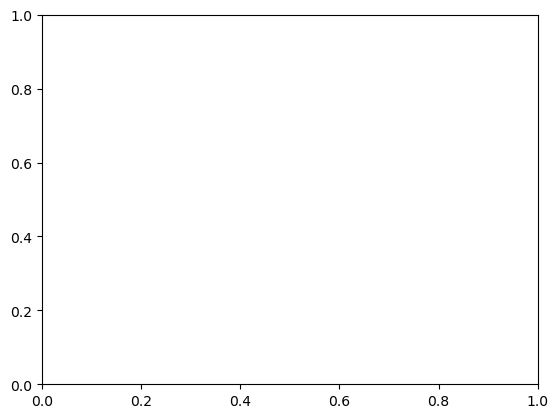

In [46]:
density_scatter(x=pd.DataFrame(y_test,columns=[targets]),
                y=pd.DataFrame(pred,columns=[targets]),line_z=1.4e12)

Model ['Vx'] Target Prediction Score: -0.00039880724344310003
Mean-squared error = 9725.453
Root-mean-squared error = 98.617714


AttributeError: 'Axes' object has no attribute 'scatter_density'

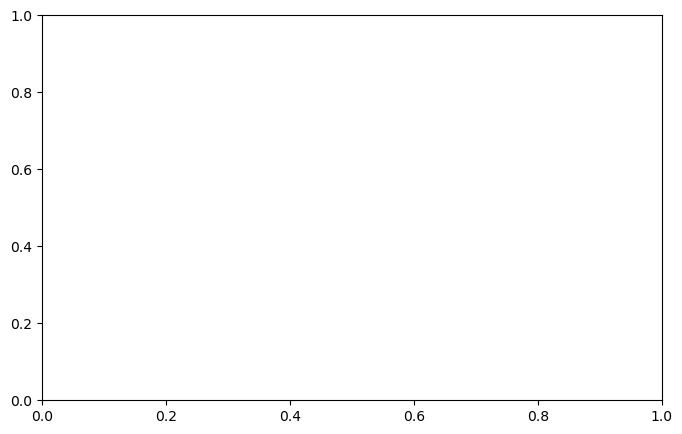

In [44]:
ml_model_performance(target=pd.DataFrame(y_test,columns=[targets]),
                     prediction=pd.DataFrame(pred,columns=[targets]),
                     target_name=targets,
                     ml_model_name='Simple RNN model',bins=[5,5])